In [1]:
import sys
sys.path.append('../')
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from funcs.analysis.analysis import *
from funcs.analysis.obj_survey import obj_survey
from funcs.preprocessing.parse import intersection, filter_data
import seaborn as sns
# import matplotlib
# font = {'size' : 18}
# matplotlib.rc('font', **font)
path = '/disk1/hrb/python/'
def reader(n_subarray):
    return pd.read_csv('../data/merged/{}/r_band/with_ssa/lc_{}.csv'.format(obj,n_subarray), comment='#', index_col = ID, dtype = {'catalogue': np.uint8, 'mag': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})

In [2]:
obj = 'qsos'
ID  = 'uid'
band = 'r'
redshift_bool = True
dr_qsos = analysis(ID, obj)
dr_qsos.band = band
dr_qsos.group(keys = [ID],read_in=True, redshift=redshift_bool, colors=True, survey = 'all')
# dr_qsos.df_grouped = dr_qsos.df_grouped.join(colors_qsos, on=ID, how='left')

In [3]:
obj = 'calibStars'
ID  = 'uid_s'
band = 'r'
redshift_bool = False
dr_star = analysis(ID, obj)
dr_star.band = band
dr_star.group(keys = [ID],read_in=True, redshift=redshift_bool, colors=True, survey='all')#, survey = 'SSS')
# dr_star.df_grouped.join(colors_stars, on=ID, how='left')

In [5]:
# Available columns
dr_qsos.df_grouped.columns

Index(['n_tot', 'mjd_min', 'mjd_max', 'mjd_ptp', 'mag_min', 'mag_max',
       'mag_mean', 'mag_med', 'mag_mean_native', 'mag_med_native',
       'mag_opt_mean', 'mag_opt_mean_flux', 'mag_std', 'magerr_max',
       'magerr_mean', 'magerr_med', 'magerr_opt_std', 'redshift', 'mjd_ptp_rf',
       'mean_gi', 'mean_gr', 'mean_ri', 'mean_iz'],
      dtype='object')

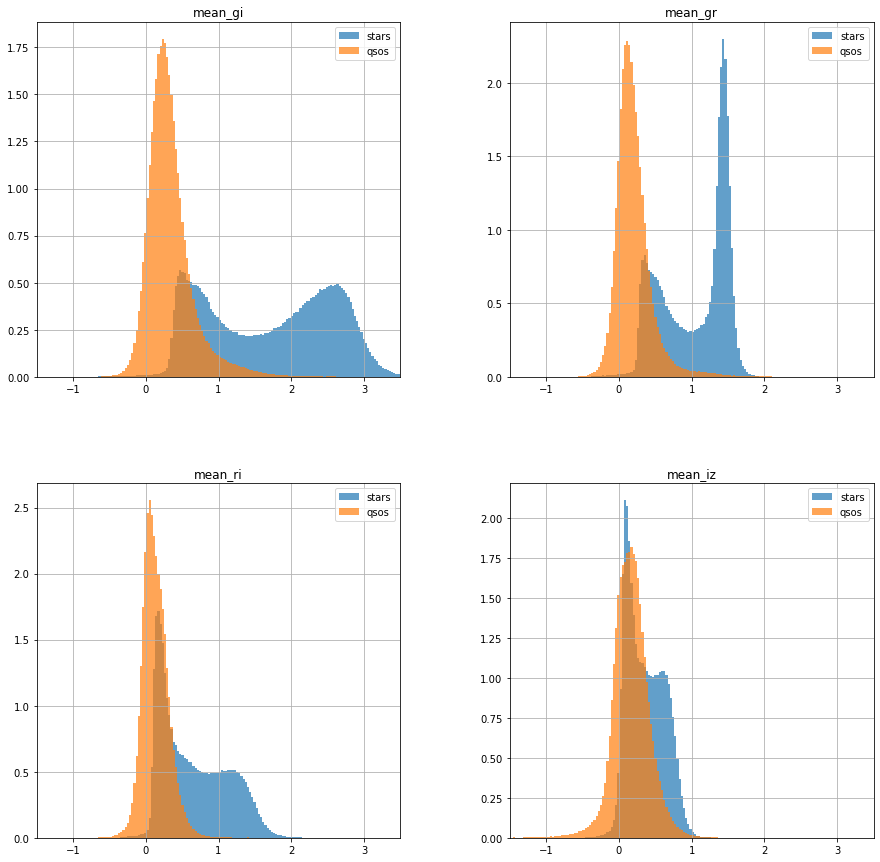

In [4]:
colors_stars = pd.read_csv(path+'data/computed/calibStars/colors_sdss.csv', index_col=0)
colors_qsos  = pd.read_csv(path+'data/computed/qsos/colors_sdss.csv', index_col=0)

fig, axes = plt.subplots(2,2, figsize=(15,15))
colors_stars.hist(ax=axes, bins=200, alpha = 0.7, density=True, range=(-2,4), label='stars')
colors_qsos .hist(ax=axes, bins=200, alpha = 0.7, density=True, range=(-2,4), label='qsos')
for ax in axes.ravel():
    ax.legend()
    ax.set(xlim=[-1.5,3.5])

2d

In [7]:
# We can move this to a method of the analysis class in analysis.py
def sns_correlate(self, xname, yname, vmin, vmax, color='blue', limits=None, colorscale=None, g=None, save=False, **kwargs):
    
    data = self.df_grouped[[xname,yname]]
    
    # Setting up limits
    if limits is None:
        lims = lambda x, n: (x.mean()-n*x.std(), x.mean()+n*x.std())
        xbounds = lims(data[xname], 3) # set the window to +/- 3 sigma from the mean
        ybounds = lims(data[yname], 2.5)
    else:
        xbounds, ybounds = limits[0], limits[1]
    bounds={xname:xbounds, yname:ybounds}
    
    # Remove data outside limits
    data = data[((xbounds[0] < data[xname])&(data[xname] < xbounds[1])) & ((ybounds[0] < data[yname])&(data[yname] < ybounds[1]))]
    
    # Setting up colors
    marg_color = {'blue':'royalblue', 'red':'salmon'}[color]
    joint_color = {'blue':'Blues', 'red':'Reds'}[color]
    
    if g is None:
        g = sns.JointGrid(x=xname, y=yname, data=data, xlim=bounds[xname], ylim=bounds[yname], height=8)
    
    # If colorscale is 'log', use log scale and vmin, vmax as limits. Otherwise, default
    if colorscale == 'log':
        from matplotlib.colors import LogNorm
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None
    # Plot
    g = g.plot_joint(plt.hexbin, norm=norm, cmap=joint_color)#, gridsize=(200,200))
#     g = sns.jointplot(x=xname, y=yname, data=data, xlim=bounds[xname], ylim=bounds[yname], height=6)
    g.ax_marg_x.hist(data[xname], bins=200, color=marg_color, alpha=0.5)
    g.ax_marg_y.hist(data[yname], bins=200, orientation='horizontal', density = True, color=marg_color, alpha=0.5)
    
    # Uncomment below to invert axis - needed when plotting absolute mag on y axis
#     g.ax_joint.invert_yaxis()

    # Set axis labels and fontsize
    g.ax_joint.set_xlabel(kwargs['xlabel'], fontsize=25)
    g.ax_joint.set_ylabel(kwargs['ylabel'], fontsize=25)
    # Increase fontsize of ticks
    g.ax_joint.tick_params(axis='both', which='major', labelsize=20)
#     g.ax_joint.set(**kwargs)

    # Uncomment below to add y=0 and x=0 dashed lines
#     plt.axhline(y=0, lw=0.2, color='k', ls='--', dashes=(20,10))
#     plt.axvline(x=0, lw=0.2, color='k', ls='--', dashes=(20,10))
    
    plt.grid(lw = 0.2, which='major')

    # Save
    if save:
        g.savefig(path+'analysis/plots/{}_{}_vs_{}.pdf'.format(self.obj,xname,yname))
    
    # Return axis handle
    return g

# QSOS
---

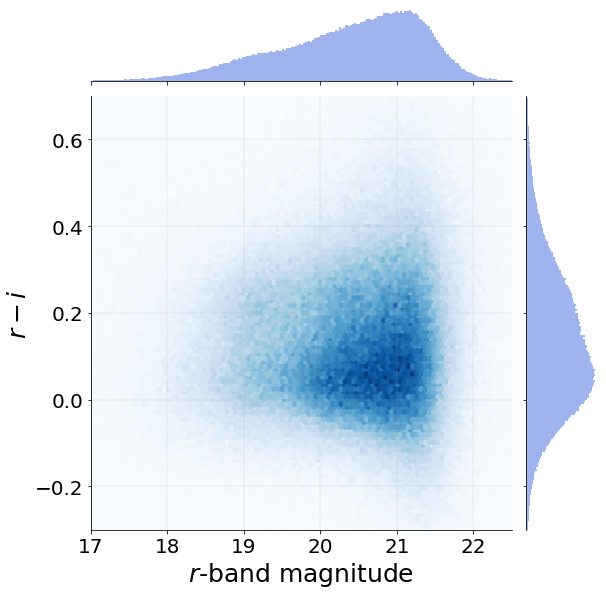

In [8]:
g = sns_correlate(dr_qsos, 'mag_mean', 'mean_ri', 1e1, 1e3, 'blue', limits = [(17,22.5),(-0.3,0.7)], save=True, xlabel=r'$r$-band magnitude', ylabel=r'$r-i$')

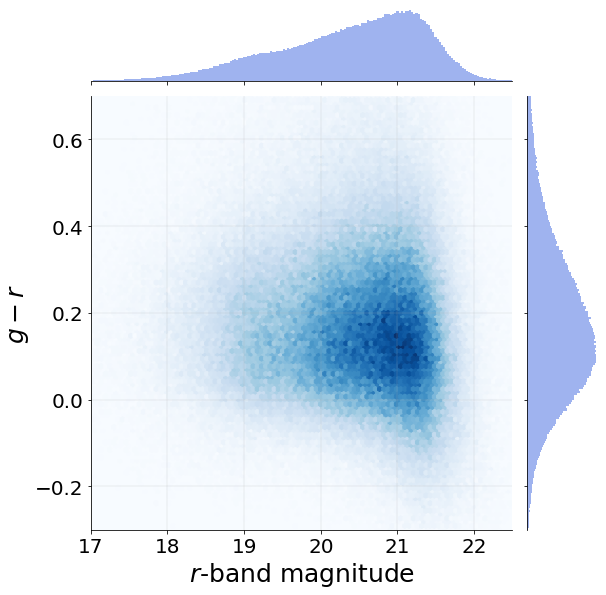

In [9]:
g = sns_correlate(dr_qsos, 'mag_mean', 'mean_gr', 1e1, 1e3, 'blue', limits = [(17,22.5),(-0.3,0.7)], save=True, xlabel=r'$r$-band magnitude', ylabel=r'$g-r$')

# STARS
---

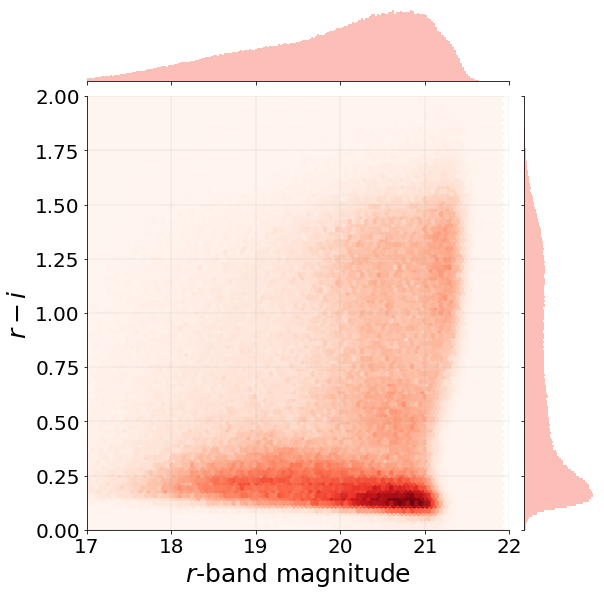

In [10]:
g = sns_correlate(dr_star, 'mag_mean', 'mean_ri', 1e1, 1e3, 'red', limits = [(17,22),(0,2)], save=True, xlabel=r'$r$-band magnitude', ylabel=r'$r-i$')

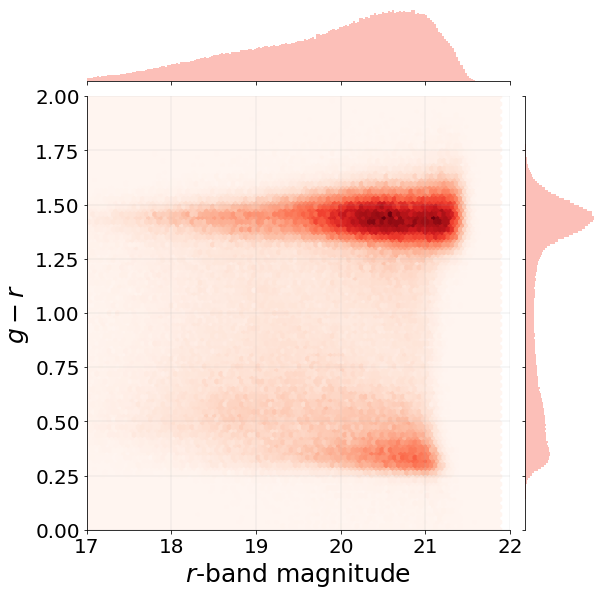

In [11]:
g = sns_correlate(dr_star, 'mag_mean', 'mean_gr', 1e1, 1e3, 'red', limits = [(17,22),(0,2)], save=True, xlabel=r'$r$-band magnitude', ylabel=r'$g-r$')